In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
diagnosis_df=pd.read_csv('../pcms_hackathon_data/train/diagnosis.csv')

In [3]:
diagnosis_df.columns

Index(['diagnosis_id', 'patient_id', 'condition_name', 'condition_type',
       'condition_description', 'is_chronic'],
      dtype='object')

In [4]:
diagnosis_df.head(3)

,diagnosis_id,patient_id,condition_name,condition_type,condition_description,is_chronic
0,3241,50975,CANCER,CHRONIC,Cancer recent medical history,t
1,3243,31228,HYPERTENSION,CHRONIC,Hypertension past medical history,t
2,3244,34922,CANCER,CHRONIC,Cancer recent medical history,t


In [5]:
diagnosis_df.shape

(3413, 6)

In [6]:
diagnosis_df.condition_name.value_counts()

condition_name
HYPERTENSION    2220
DIABETES         917
CANCER           276
Name: count, dtype: int64

In [7]:
diagnosis_df.isnull().sum()

diagnosis_id             0
patient_id               0
condition_name           0
condition_type           0
condition_description    0
is_chronic               0
dtype: int64

In [8]:
diagnosis_df.condition_type.value_counts()

condition_type
CHRONIC    3413
Name: count, dtype: int64

In [9]:
diagnosis_df.condition_description.value_counts()

condition_description
Hypertension past medical history               2220
Diabetes mellitus past medical history           917
Cancer recent medical history                    116
Breast cancer past medical history                92
Prostate cancer past medical history              37
Colorectal cancer past medical history            16
High risk breast cancer past medical history      15
Name: count, dtype: int64

In [10]:
diagnosis_df.is_chronic.value_counts()

is_chronic
t    3413
Name: count, dtype: int64

In [11]:
len(diagnosis_df.patient_id.unique())

2617

In [12]:
diagnosis_df['has_diabetes'] = (diagnosis_df['condition_name'] == 'DIABETES').astype(int)
diagnosis_df['has_hypertension'] = (diagnosis_df['condition_name'] == 'HYPERTENSION').astype(int)
diagnosis_df['has_cancer'] = (diagnosis_df['condition_name'] == 'CANCER').astype(int)

diagnosis_features = diagnosis_df.groupby('patient_id').agg({
    'condition_name': 'nunique',
    'has_diabetes': 'max',
    'has_hypertension': 'max',
    'has_cancer': 'max'
}).reset_index()

diagnosis_features.rename(columns={'condition_name': 'num_chronic_conditions'}, inplace=True)


In [13]:
diagnosis_features

,patient_id,num_chronic_conditions,has_diabetes,has_hypertension,has_cancer
0,19,1,0,0,1
1,46,1,0,1,0
2,137,2,0,1,1
3,161,2,1,1,0
4,186,2,1,1,0
...,...,...,...,...,...
2612,81884,1,0,0,1
2613,81946,1,0,1,0
2614,81948,2,1,1,0
2615,81999,1,0,1,0


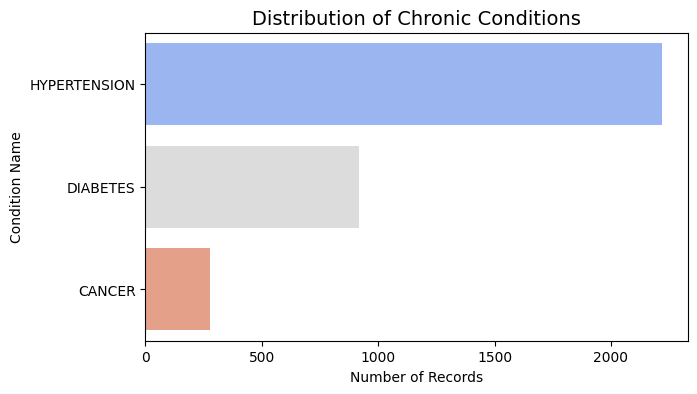

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4))
sns.countplot(y='condition_name', data=diagnosis_df, order=diagnosis_df['condition_name'].value_counts().index, palette='coolwarm')
plt.title('Distribution of Chronic Conditions', fontsize=14)
plt.xlabel('Number of Records')
plt.ylabel('Condition Name')
plt.show()


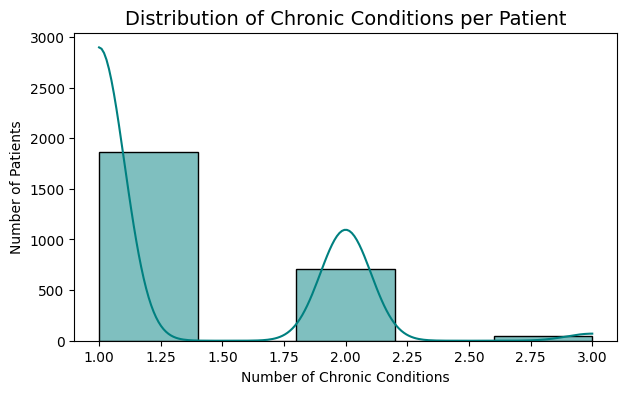

In [15]:
patient_condition_count = diagnosis_df.groupby('patient_id')['condition_name'].nunique().reset_index(name='num_conditions')

plt.figure(figsize=(7,4))
sns.histplot(patient_condition_count['num_conditions'], bins=5, kde=True, color='teal')
plt.title('Distribution of Chronic Conditions per Patient', fontsize=14)
plt.xlabel('Number of Chronic Conditions')
plt.ylabel('Number of Patients')
plt.show()


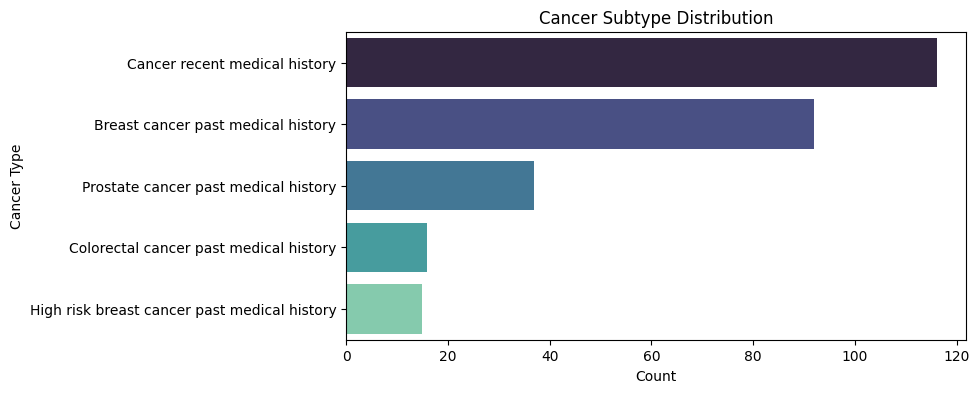

In [16]:
cancer_subtypes = diagnosis_df[diagnosis_df['condition_name'] == 'CANCER']['condition_description'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(x=cancer_subtypes.values, y=cancer_subtypes.index, palette='mako')
plt.title('Cancer Subtype Distribution')
plt.xlabel('Count')
plt.ylabel('Cancer Type')
plt.show()


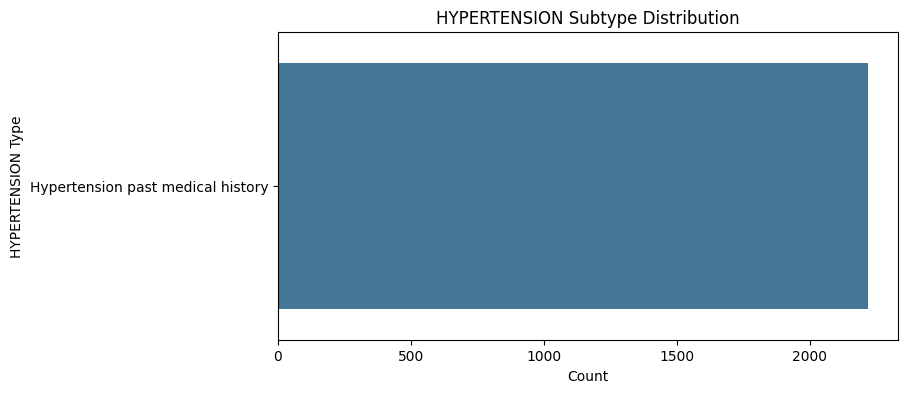

In [17]:
cancer_subtypes = diagnosis_df[diagnosis_df['condition_name'] == 'HYPERTENSION']['condition_description'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(x=cancer_subtypes.values, y=cancer_subtypes.index, palette='mako')
plt.title('HYPERTENSION Subtype Distribution')
plt.xlabel('Count')
plt.ylabel('HYPERTENSION Type')
plt.show()


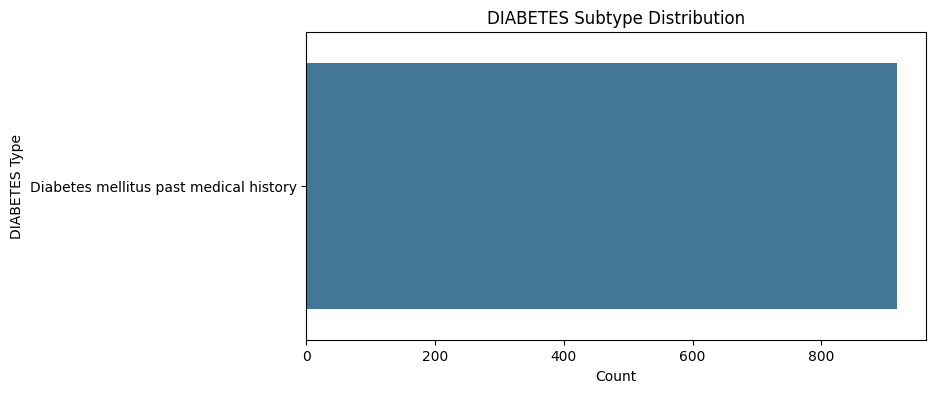

In [18]:
cancer_subtypes = diagnosis_df[diagnosis_df['condition_name'] == 'DIABETES']['condition_description'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(x=cancer_subtypes.values, y=cancer_subtypes.index, palette='mako')
plt.title('DIABETES Subtype Distribution')
plt.xlabel('Count')
plt.ylabel('DIABETES Type')
plt.show()


In [19]:
cond_name_dummies = pd.get_dummies(diagnosis_df['condition_name'], prefix='cond')

cond_desc_dummies = pd.get_dummies(diagnosis_df['condition_description'], prefix='desc')

diagnosis_binary = pd.concat(
    [diagnosis_df[['patient_id']], cond_name_dummies, cond_desc_dummies],
    axis=1
)

diagnosis_binary = diagnosis_binary.groupby('patient_id').max().reset_index()

diagnosis_agg = (
    diagnosis_df.groupby('patient_id')
    .agg({
        'condition_name': 'nunique',
        'is_chronic': lambda x: (x == 't').sum()
    })
    .reset_index()
    .rename(columns={
        'condition_name': 'num_conditions',
        'is_chronic': 'num_chronic_conditions'
    })
)

diagnosis_final = diagnosis_agg.merge(diagnosis_binary, on='patient_id', how='left')


diagnosis_final.fillna(0, inplace=True)


print("Diagnosis table aggregated successfully!")
print("Shape:", diagnosis_final.shape)
# print(diagnosis_final.head())


Diagnosis table aggregated successfully!
Shape: (2617, 13)


In [20]:
diagnosis_final['has_cancer_history'] = (
    diagnosis_final.filter(like='CANCER').sum(axis=1) > 0
).astype(int)


In [21]:
diagnosis_final.head(3)

,patient_id,num_conditions,num_chronic_conditions,cond_CANCER,cond_DIABETES,cond_HYPERTENSION,desc_Breast cancer past medical history,desc_Cancer recent medical history,desc_Colorectal cancer past medical history,desc_Diabetes mellitus past medical history,desc_High risk breast cancer past medical history,desc_Hypertension past medical history,desc_Prostate cancer past medical history,has_cancer_history
0,19,1,1,True,False,False,True,False,False,False,False,False,False,1
1,46,1,1,False,False,True,False,False,False,False,False,True,False,0
2,137,2,2,True,False,True,True,False,False,False,False,True,False,1


In [22]:
diagnosis_final['chronic_condition_ratio'] = np.where(
    diagnosis_final['num_conditions'] > 0,
    diagnosis_final['num_chronic_conditions'] / diagnosis_final['num_conditions'],
    0
)


In [23]:
diagnosis_final.head(3)

,patient_id,num_conditions,num_chronic_conditions,cond_CANCER,cond_DIABETES,cond_HYPERTENSION,desc_Breast cancer past medical history,desc_Cancer recent medical history,desc_Colorectal cancer past medical history,desc_Diabetes mellitus past medical history,desc_High risk breast cancer past medical history,desc_Hypertension past medical history,desc_Prostate cancer past medical history,has_cancer_history,chronic_condition_ratio
0,19,1,1,True,False,False,True,False,False,False,False,False,False,1,1.0
1,46,1,1,False,False,True,False,False,False,False,False,True,False,0,1.0
2,137,2,2,True,False,True,True,False,False,False,False,True,False,1,1.0


In [24]:
diagnosis_final.chronic_condition_ratio.value_counts()

chronic_condition_ratio
1.0    2617
Name: count, dtype: int64

In [25]:
diagnosis_final.head(3)

,patient_id,num_conditions,num_chronic_conditions,cond_CANCER,cond_DIABETES,cond_HYPERTENSION,desc_Breast cancer past medical history,desc_Cancer recent medical history,desc_Colorectal cancer past medical history,desc_Diabetes mellitus past medical history,desc_High risk breast cancer past medical history,desc_Hypertension past medical history,desc_Prostate cancer past medical history,has_cancer_history,chronic_condition_ratio
0,19,1,1,True,False,False,True,False,False,False,False,False,False,1,1.0
1,46,1,1,False,False,True,False,False,False,False,False,True,False,0,1.0
2,137,2,2,True,False,True,True,False,False,False,False,True,False,1,1.0


In [26]:
condition_counts = (
    diagnosis_df
    .groupby(['patient_id', 'condition_name'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)


condition_counts.rename(columns={
    'CANCER': 'cancer_count',
    'DIABETES': 'diabetes_count',
    'HYPERTENSION': 'hypertension_count'
}, inplace=True)


diagnosis_final = diagnosis_final.merge(condition_counts, on='patient_id', how='left')

diagnosis_final[['cancer_count', 'diabetes_count', 'hypertension_count']] = (
    diagnosis_final[['cancer_count', 'diabetes_count', 'hypertension_count']].fillna(0).astype(int)
)

print("Added per-patient condition counts!")
print(diagnosis_final[['patient_id', 'cancer_count', 'diabetes_count', 'hypertension_count']].head())


Added per-patient condition counts!
   patient_id  cancer_count  diabetes_count  hypertension_count
0          19             1               0                   0
1          46             0               0                   1
2         137             1               0                   1
3         161             0               1                   1
4         186             0               1                   1


In [27]:
diagnosis_final

,patient_id,num_conditions,num_chronic_conditions,cond_CANCER,cond_DIABETES,cond_HYPERTENSION,desc_Breast cancer past medical history,desc_Cancer recent medical history,desc_Colorectal cancer past medical history,desc_Diabetes mellitus past medical history,desc_High risk breast cancer past medical history,desc_Hypertension past medical history,desc_Prostate cancer past medical history,has_cancer_history,chronic_condition_ratio,cancer_count,diabetes_count,hypertension_count
0,19,1,1,True,False,False,True,False,False,False,False,False,False,1,1.0,1,0,0
1,46,1,1,False,False,True,False,False,False,False,False,True,False,0,1.0,0,0,1
2,137,2,2,True,False,True,True,False,False,False,False,True,False,1,1.0,1,0,1
3,161,2,2,False,True,True,False,False,False,True,False,True,False,0,1.0,0,1,1
4,186,2,2,False,True,True,False,False,False,True,False,True,False,0,1.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2612,81884,1,1,True,False,False,False,False,True,False,False,False,False,1,1.0,1,0,0
2613,81946,1,1,False,False,True,False,False,False,False,False,True,False,0,1.0,0,0,1
2614,81948,2,2,False,True,True,False,False,False,True,False,True,False,0,1.0,0,1,1
2615,81999,1,1,False,False,True,False,False,False,False,False,True,False,0,1.0,0,0,1
